In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import dask
import xarray as xr
from dask.diagnostics import ProgressBar

import joblib
from sklearn.pipeline import Pipeline
from dask_ml.preprocessing import StandardScaler
from dask_ml.decomposition import PCA

#from dask_ml.xgboost import XGBRegressor
#from dask_ml.linear_model import LogisticRegression
#from dask_ml.linear_model import LinearRegression
from sklearn.linear_model import Ridge

import keras
from keras.layers.core import Dropout

Using Theano backend.


In [2]:
import sys
print(sys.executable)

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/bin/python3


In [3]:
def shift_time(ds, value):
    ds.coords['time'].values = pd.to_datetime(ds.coords['time'].values) + value
    return ds

In [4]:
static = xr.open_dataset('../data/usa/era5_slt_z_slor_lsm_stationary_field.nc')

In [5]:
era5 = xr.open_dataset('../data/usa/era5_lsp_cp_1981-2017_daysum.nc')
era5 = shift_time(era5, -dt.timedelta(hours=23))

In [6]:
glofas = xr.open_dataset('../data/usa/glofas_reanalysis_usa_1981-2002.nc')
glofas = glofas.rename({'lat': 'latitude', 'lon': 'longitude'})  # to have the same name like in era5
glofas = shift_time(glofas, -dt.timedelta(days=1))
# da.transpose(dims='latitude')  # flip?

In [7]:
glofas = glofas.isel(time=slice(0, 365*20))  # just to reduce the amount of data

### basic spatial subset - compute the model only in this domain

In [8]:
box_model = dict(latitude=slice(40, 28), 
                 longitude=slice(-95, -85))

In [9]:
glofas = glofas.sel(box_model)
era5 = era5.sel(box_model)

In [10]:
dis = glofas['dis']

In [11]:
z_glofas = static['z'].isel(time=0)/9.81  # converting to m approx.
z_glofas = z_glofas.interp(latitude=glofas.latitude,
                           longitude=glofas.longitude)
z_glofas = z_glofas.drop('time')  # time is misleading as the topography does not change

In [12]:
tp = (era5['cp']+era5['lsp'])*1000
tp.name = 'total precip [mm]'
tp = tp.interp(latitude=glofas.latitude,
               longitude=glofas.longitude)

# Preprocessing routines - Summary

In [13]:
def add_shifted_predictors(ds, shifts, variables='all'):
    """Adds additional variables to an array which are shifted in time.
    
    Parameters
    ----------
    ds : xr.Dataset
    shifts : list of integers
    variables : str or list
    """
    if variables == 'all': 
        variables = ds.data_vars
        
    for var in variables:
        for i in shifts:
            if i == 0: continue  # makes no sense to shift by zero
            newvar = var+'-'+str(i)
            ds[newvar] = ds[var].shift(time=i)
    return ds

In [14]:
def correlate(da_3d, da_timeseries, timelag=False):
    a = da_3d - da_3d.mean('time')
    b = da_timeseries - da_timeseries.mean('time')
    N = len(b.coords['time'])
    if timelag:
        b = b.drop('time')
        a = a.drop('time')
    out = b.dot(a)/a.std('time')/b.std()/N
    out.name = 'correlation coefficient'
    return out

In [15]:
def select_river(dis):
    river = dis.min('time') > 5
    river.name = 'river mask [0/1]'
    return river

In [16]:
def select_upstream_river(dis_box, dis_point, z_box, z_point, rivermask, pct):
    lags = [-1, 1]

    timelag_corrs = np.full((len(lags), len(dis_box.latitude), len(dis_box.longitude)), np.nan)
    for t, lag in enumerate(lags):
        if lag > 0:  # dis_box with data from previous timesteps
            cntr = dis_point[lag:]
            dis_box_shift = dis_box[:-lag]
        elif lag < 0:  # dis_box with data from future timesteps
            cntr = dis_point[:lag]
            dis_box_shift = dis_box[-lag:]

        dis_box_relevant = dis_box_shift.where(rivermask==1)
        timelag_corrs[t,:,:] = correlate(dis_box_relevant, cntr, timelag=True)

    lag_influencing = timelag_corrs[1,:,:]>timelag_corrs[0,:,:]
    #plt.imshow(lag_influencing)

    influencer = (dis_box.mean('time') > pct*dis_point.mean('time'))  \
                  &(z_box > z_point)   \
                  &(rivermask==1) & lag_influencing
    influencer.name = 'gridpoints influencing discharge [0/1]'
    #influencer.plot()
    return influencer

In [17]:
shifts = range(1,4)
X_dis = add_shifted_predictors(glofas, shifts, variables='all')
X_dis = X_dis.drop('dis')  # we actually want to predict (t) with (t-1, t-2, t-3)
y_dis = glofas['dis']

In [18]:
i, j = 70, 38
di = 20
dj = 20
pct = 0.1  # influencing gridpoint must have mean discharge more than this percentage

i0, i1 = i-di, i+di
j0, j1 = j-dj, j+dj

In [19]:
tp_box = tp[:, i0:i1, j0:j1]
noprecip = tp_box.mean(['longitude', 'latitude']) < 0.1
print('percentage:',sum(noprecip.astype(int))/noprecip.size) # .plot() #.plot() #'#'
print(noprecip)

percentage: <xarray.DataArray 'total precip [mm]' ()>
array(0.334986)
<xarray.DataArray 'total precip [mm]' (time: 13514)>
array([ True,  True,  True, ...,  True, False, False])
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2017-12-31


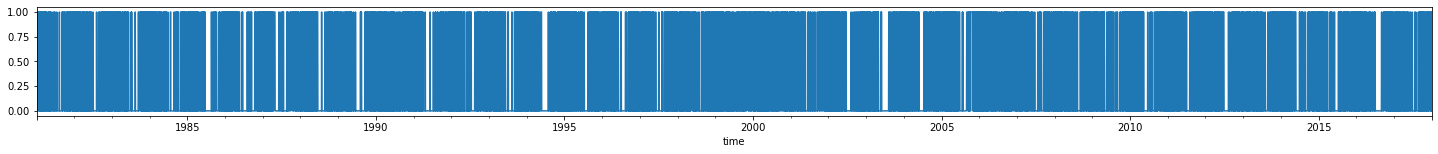

In [20]:
fig, ax = plt.subplots(figsize=(25,2))
noprecip.astype(int).to_pandas().plot(ax=ax)

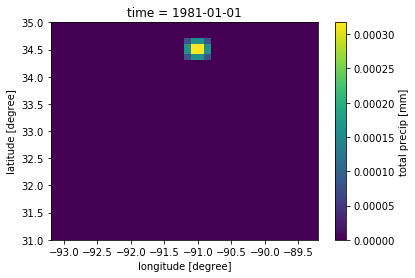

In [21]:
tp_box.where(noprecip).isel(time=0).plot()

### pre-selection of upstream river gridpoints

In [22]:
dis_point = dis[:,i,j]
dis_box = dis[:, i0:i1, j0:j1]
z_point = z_glofas[i,j]
z_box = z_glofas[i0:i1,j0:j1]


rivermask = select_river(dis_box)

upstream = select_upstream_river(dis_box, dis_point, z_box, z_point, rivermask, pct)

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<xarray.DataArray 'gridpoints influencing discharge [0/1]' ()>
array(26)


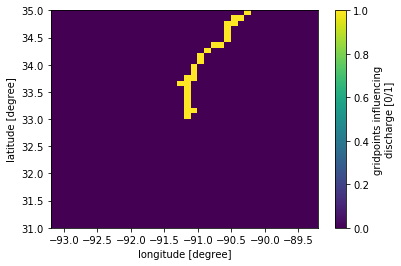

In [23]:
upstream.plot()
print(upstream.sum())

# Parameter-tuning for reasonable performance

In [24]:
def preprocess_reshape(X_dis, y_dis, i, j):
    """Reshape, merge predictor/predictand in time, drop nans."""
    X_dis = X_dis.to_array(dim='time_feature')  
    X_dis = X_dis.stack(features=['latitude', 'longitude', 'time_feature'])
    Xar = X_dis.dropna('features', how='all')
    
    yar = y_dis[:,i,j]
    yar = yar.drop(['latitude', 'longitude'])
    yar.coords['features'] = 'dis'
    
    Xy = xr.concat([Xar, yar], dim='features')
    Xyt = Xy.dropna('time', how='any')  # drop them as we cannot train on nan values
    time = Xyt.time
    
    Xda = Xyt[:,:-1]
    yda = Xyt[:,-1]
    return Xda, yda, time

In [25]:
# space subset, dimensionality reduction
X_dis = X_dis.where(upstream)

# time subset
X_dis = X_dis.where(noprecip)
y_dis = y_dis.where(noprecip)
    
Xda, yda, time = preprocess_reshape(X_dis, y_dis, i,j)

In [26]:
N_train = 365*3
N_valid = 365

X_train = Xda[:N_train,:]
y_train = yda[:N_train]
X_valid = Xda[N_train:N_train+N_valid,:]
y_valid = yda[N_train:N_train+N_valid]

print(Xda.shape)
print('train shapes:', X_train.shape, y_train.shape)
print('valid shapes:', X_valid.shape, y_valid.shape)

(2392, 78)
train shapes: (1095, 78) (1095,)
valid shapes: (365, 78) (365,)


In [27]:
def add_time(vector, time, name=None):
    """Converts arrays to xarrays with a time coordinate."""
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)

class KerasDenseNN(object):
    def __init__(self, **kwargs):
        model = keras.models.Sequential()
        self.cfg = kwargs
        
        model.add(keras.layers.BatchNormalization())
        
        model.add(keras.layers.Dense(8,
                                  kernel_initializer='normal', 
                                  bias_initializer='zeros',
                                  activation='relu')) #('sigmoid'))
        #model.add(Dropout(self.cfg.get('dropout')))
        #model.add(keras.layers.Dense(32))
        #model.add(keras.layers.Activation('sigmoid'))
        #model.add(Dropout(self.cfg.get('dropout')))
        #model.add(keras.layers.Dense(16))
        #model.add(keras.layers.Activation('sigmoid'))
        #model.add(Dropout(self.cfg.get('dropout')))
        #model.add(keras.layers.Dense(8))
        #model.add(keras.layers.Activation('sigmoid'))
        #model.add(Dropout(self.cfg.get('dropout')))
        model.add(keras.layers.Dense(1, activation='linear'))
        #                     bias_initializer=keras.initializers.Constant(value=9000)))
        
        #ha = self.cfg.get('hidden_activation')

        #for N_nodes in self.cfg.get('N_hidden_nodes'):
        #        
        #    model.add(hidden)
        #    model.add(ha.copy())
        #    
        #    if self.cfg.get('dropout'):
        #        model.add(Dropout(self.cfg.get('dropout')))#

        #outputlayer = keras.layers.Dense(1, activation='linear')

        #optimizer_name, options_dict = self.cfg.get('optimizer')
        #optimizer = getattr(keras.optimizers, optimizer_name)(**options_dict)
        #optimizer = keras.optimizers.SGD(lr=0.01)
        rmsprop = keras.optimizers.RMSprop(lr=.1)
        sgd = keras.optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.5, nesterov=True)

        model.compile(loss=self.cfg.get('loss'), 
                      optimizer=rmsprop)
        self.model = model

        self.callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                            min_delta=1, patience=100, verbose=0, mode='auto',
                            baseline=None, restore_best_weights=True),]

    def predict(self, Xda, name=None):
        a = self.model.predict(Xda.values).squeeze()
        return add_time(a, Xda.time, name=name)

    def fit(self, Xda, yda, **kwargs):
        return self.model.fit(Xda.values, yda.values.reshape(-1,1),
                              epochs=self.cfg.get('epochs', None),
                              batch_size=self.cfg.get('batch_size', None),
                              callbacks=self.callbacks,
                              verbose=0,
                              **kwargs)

In [28]:
mlp_kws = dict(optimizer=('sgd', dict(lr=1)),
               loss='mean_squared_error',
               #N_hidden_nodes=(4,4),
               #hidden_activation=keras.layers.Activation('sigmoid'), #keras.layers.ReLU(), #-LeakyReLU(alpha=0.3), #'relu',
               #output_activation='linear',
               #bias_initializer='random_uniform',
               batch_size=128,
               dropout=0., #.25,
               epochs=1000,
              )


linear_kws = dict(C=.1, n_jobs=-1, max_iter=10000, verbose=True)


if False:
    pipe = Pipeline([('scaler', StandardScaler()),
                     ('pca', PCA(n_components=4)),
                     ('model', LinearRegression(**linear_kws)),],
                    verbose=True)
if True:
    pipe = Pipeline([#('scaler', StandardScaler()),
                     #('pca', PCA(n_components=2)),
                     ('model', KerasDenseNN(**mlp_kws)),],
                    verbose=False)
    

In [29]:
pipe

Pipeline(memory=None,
         steps=[('model', <__main__.KerasDenseNN object at 0x7f5b722e1da0>)],
         verbose=False)

In [30]:
history = pipe.fit(X_train, y_train,
                   model__validation_data=(X_valid, #.values, 
                                           y_valid)) #.values.reshape(-1,1)))

In [31]:
keras.utils.print_summary(pipe.named_steps['model'].model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 78)                312       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 632       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 953
Trainable params: 797
Non-trainable params: 156
_________________________________________________________________


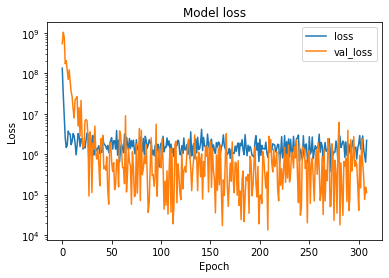

In [32]:
h = history.named_steps['model'].model.history

# Plot training & validation loss values
plt.plot(h.history['loss'], label='loss')
plt.plot(h.history['val_loss'], label='val_loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend() #['Train', 'Test'], loc='upper left')
plt.gca().set_yscale('log')
plt.show()

# Test it on the same data

In [33]:
y_train_pred = pipe.predict(X_train, name='dis-fcst-train')
y_valid_pred = pipe.predict(X_valid, name='dis-fcst-valid')

In [34]:
X_valid.values.shape

(365, 78)

(723181.0, 726629.0)

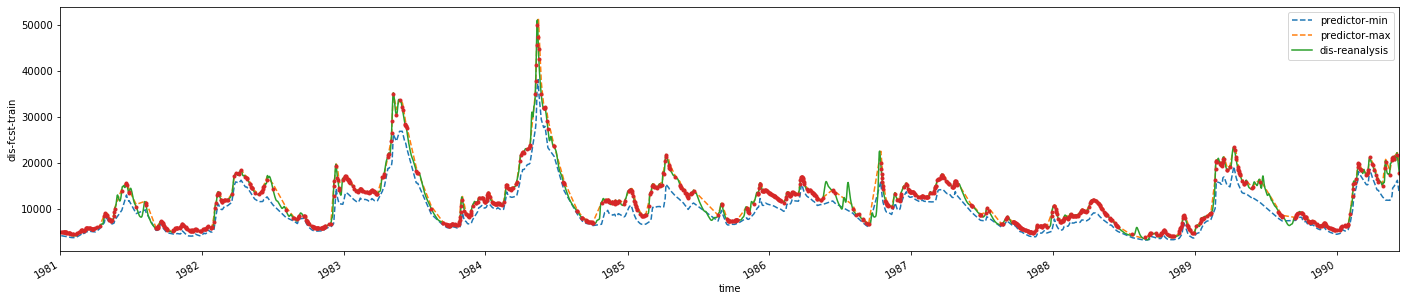

In [42]:
fig, ax = plt.subplots(figsize=(24,5))
minpred = X_train.min('features')
maxpred = X_train.max('features')

minpred.plot(ax=ax, linestyle='--', label='predictor-min')
maxpred.plot(ax=ax, linestyle='--', label='predictor-max')


dis[:,i,j].to_pandas().plot(ax=ax, label='dis-reanalysis')
y_train_pred.plot(ax=ax, marker='.', lw=0)

plt.legend()
plt.gca().set_xlim(dt.datetime(1981,1,1), y_train_pred.time.values[-1]) 

(726630.0, 727717.0)

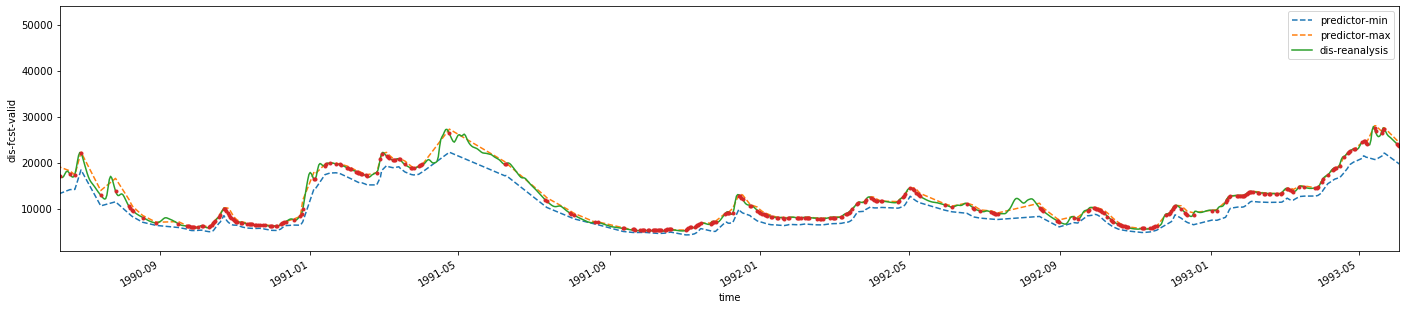

In [37]:
fig, ax = plt.subplots(figsize=(24,5))
minpred = add_time(Xda.min(axis=1), time)
maxpred = add_time(Xda.max(axis=1), time)

minpred.plot(ax=ax, linestyle='--', label='predictor-min')
maxpred.plot(ax=ax, linestyle='--', label='predictor-max')

dis[:,i,j].to_pandas().plot(ax=ax, label='dis-reanalysis')
y_valid_pred.plot(ax=ax, marker='.', lw=0)

plt.legend()
plt.gca().set_xlim(y_valid_pred.time.values[0], y_valid_pred.time.values[-1]) 

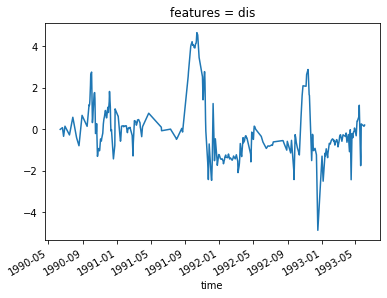

## Verification

Is the NN model better than using the max value of all predictors?

In [ ]:
def to_5yr(dis):
    return dis/glofas_rl['rl5'].sel(latitude=dis.latitude, longitude=dis.longitude)

In [ ]:
((y_train_pred-y_train)/y_train*100).plot(label=)
X_train.max('features').plot(label='max_feature')

In [ ]:
((y_valid_pred-y_valid)/y_valid*100).plot()